<a href="https://colab.research.google.com/github/abelowska/eegML/blob/main/Classes_06_feature_extraction_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature extraction and selection


In this notebook you will learn about:
- Feature Selection methods:
  - [Filter methods](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/) based on the statistical tests;
  - [Wrapper methods](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/) based on the model performance evaluated with cross-validation;
- Feature Extraction Method with Principal Component Analysis

Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

import io
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, SelectFpr, SelectFdr, SequentialFeatureSelector

In [ ]:
# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

In [ ]:
# constants
test_size = 0.2
random_state = 42
cv = 3

## Load the Life Expectancy Dataset

In [ ]:
# To upload from your local drive, start with the following code. 
# It will prompt you to select a file. Click on “Choose Files” 
# then select and upload the .csv file you downloaded. 

from google.colab import files
uploaded = files.upload()

Saving Life_Expectancy_Data.csv to Life_Expectancy_Data.csv


In [ ]:
# make sure the filename matches the name of the uploaded file 
life_expectancy_data = pd.read_csv(io.BytesIO(uploaded['Life_Expectancy_Data.csv']))
life_expectancy_df = life_expectancy_data.copy()

In [ ]:
life_expectancy_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
# drop NaN values
life_expectancy_df = life_expectancy_df.dropna() 

# select first 50 samples to make the problem harder
life_expectancy_df = life_expectancy_df[:50]

### Inspect the data

## Prepare data

Up to now, we have been selecting one or a few values from our lifespan dataset. Now, however, we would like to model a more realistic case - we have a whole dataset and we can use the whole dataset.

In [ ]:
X = life_expectancy_df.drop(labels = ["Life expectancy ","Country", "Status"], axis=1)

In [ ]:
y = life_expectancy_df[["Life expectancy "]]

### Train-test split

In [ ]:
# to ensure repeatability of splits, we set the random state
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=test_size, 
    random_state=random_state
)

## Model fitting

In [ ]:
# define models with defaults parameters

lm = LinearRegression()
svr = SVR()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor(random_state=random_state)

estimators = [
    ('ln', lm), 
    ("svr", svr), 
    ("knn", knn), 
    ("dt", tree)
]

We'll create function for model evaluation to not multiply the same code.

In [ ]:
def evaluate_model(
    pipe, 
    X_train, 
    y_train, 
    X_test, 
    y_test,
    pipeline_name, 
    cv=KFold(n_splits=3),
    predict_test = True, 
    predict_train = True
  ):
  '''
  Takes Pipeline model, train and test data and whether to predicto on test and train sets. 
  Fit model and evaluate it according to the parameters.
  '''

  # compute cross validated scores on train data
  cv_scores = cross_val_score(pipe, X_train, y_train.to_numpy().ravel(), cv=cv)
  mean_cv_score = np.mean(cv_scores)

  # fit model
  # .ravel() flattens array into 1D - we ensure that y is (n_samples,)
  pipe.fit(X_train, y_train.to_numpy().ravel())

  # predict test data
  y_test_pred = pipe.predict(X_test) if predict_test is True else None
  test_score = r2_score(y_test, y_test_pred) if predict_test is True else None

  # predict train data
  y_train_pred = pipe.predict(X_train) if predict_train is True else None
  train_score = r2_score(y_train, y_train_pred) if predict_train is True else None 

  # define model name
  model_name = type(estimator).__name__

  # save results in dataframe
  this_result = pd.DataFrame({
            "model_name": [pipe.steps[-1][0]],
            "pipeline_name": [pipeline_name],
            "train score": [train_score],
            "mean_cv_score": [mean_cv_score],
            "test_score": [test_score],
            "model": [pipe],
            "cv_scores": [cv_scores]
            })
  
  return this_result

In [ ]:
results_df = pd.DataFrame()

### 1. Base pre-processing


Define bese steps

In [ ]:
pipeline_name = "base"
base_steps = [
      ('scaler', StandardScaler()), 
]

Evaluate Pipeline

In [ ]:
for estimator in estimators:
  print(f"Rating {estimator} \n")

  # create pipeline from base steps list and estimator
  pipe = Pipeline(base_steps + [estimator])

  # enter to grid search
  this_results = evaluate_model(
      pipe,
      X_train,
      y_train,
      X_test,
      y_test,
      pipeline_name = pipeline_name,
      predict_test = True,
      predict_train = True,
  )

  results_df = results_df.append(this_results)

Rating ('ln', LinearRegression()) 

Rating ('svr', SVR()) 

Rating ('knn', KNeighborsRegressor()) 

Rating ('dt', DecisionTreeRegressor(random_state=42)) 



In [ ]:
results_df

,model_name,pipeline_name,train score,mean_cv_score,test_score,model,cv_scores
0,ln,base,0.999019,0.689423,-3.204231,"(StandardScaler(), LinearRegression())","[0.9610431294543971, 0.1163025850632673, 0.990..."
0,svr,base,0.740278,0.447586,0.633629,"(StandardScaler(), SVR())","[0.30837891164507514, 0.4870817047857554, 0.54..."
0,knn,base,0.987590,0.956695,0.963470,"(StandardScaler(), KNeighborsRegressor())","[0.9597318837591046, 0.9351837698449684, 0.975..."
0,dt,base,1.000000,0.898617,0.972479,"(StandardScaler(), DecisionTreeRegressor(rando...","[0.8132347886816629, 0.9239533263207418, 0.958..."


## 2. Feature Selection 

Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.

Having irrelevant features in your data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression.

Three benefits of performing feature selection before modeling your data are:

- **Reduces Overfitting**: Less redundant data means less opportunity to make decisions based on noise.
- **Improves Accuracy**: Less misleading data means modeling accuracy improves.
- **Reduces Training Time**: Less data means that algorithms train faster.

You can learn more about feature selection with scikit-learn in the article [Feature selection](http://scikit-learn.org/stable/modules/feature_selection.html).

This notebook covers two main ML methods for feature selection:

  1. Filter methods
  2. Wrapper methods

### 2.1 Filter methods

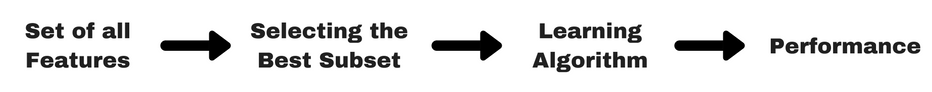

- they are supervised algorithms;
- the "efficiency" is based on correlation coefficients: in the case of continuous input/output specifically on Pearson’s Correlation.

#### 1. K Best

Select features according to the k highest scores.

In [ ]:
# select K best - returning a pair of arrays (scores, pvalues) and select K best
k = 5
pipeline_name = f"KBest"

base_steps = [
    ('scaler', StandardScaler()), 
    ('feature_selection', SelectKBest(score_func=f_regression, k=k)),
]

In [ ]:
for estimator in estimators:
  print(f"Rating {estimator} \n")

  # create pipeline from base steps list and estimator
  pipe = Pipeline(base_steps + [estimator])

  # enter to grid search
  this_results = evaluate_model(
      pipe,
      X_train,
      y_train,
      X_test,
      y_test,
      pipeline_name = pipeline_name,
      predict_test = True,
      predict_train = True,
  )

  results_df = results_df.append(this_results)

Rating ('ln', LinearRegression()) 

Rating ('svr', SVR()) 

Rating ('knn', KNeighborsRegressor()) 

Rating ('dt', DecisionTreeRegressor(random_state=42)) 



In [ ]:
results_df

,model_name,pipeline_name,train score,mean_cv_score,test_score,model
0,ln,base,0.999019,0.689423,-3.204231,"(StandardScaler(), LinearRegression())"
0,svr,base,0.740278,0.447586,0.633629,"(StandardScaler(), SVR())"
0,knn,base,0.987590,0.956695,0.963470,"(StandardScaler(), KNeighborsRegressor())"
0,dt,base,1.000000,0.898617,0.972479,"(StandardScaler(), DecisionTreeRegressor(rando..."
0,ln,KBest,0.979646,0.954118,0.888622,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,svr,KBest,0.882518,0.837028,0.735234,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,knn,KBest,0.979721,0.944716,0.972270,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,dt,KBest,1.000000,0.871734,0.894119,"(StandardScaler(), SelectKBest(k=5, score_func..."


Inspect data after KBest selection:

In [ ]:
# extract pipe before estimator
kbest_pipe = results_df['model'].iloc[-1][:-1]
kbest_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x7f2e9a74e5f0>))])

In [ ]:
# transform data
X_kbest = kbest_pipe.transform(X_test)
print(f"X set shape after feature selection: {X_kbest.shape}\n")

# print feature names that were selected
print(f"Selected Features: {*kbest_pipe.get_feature_names_out(),}")

X set shape after feature selection: (10, 5)

Selected Features: ('Adult Mortality', 'infant deaths', ' BMI ', 'under-five deaths ', 'Income composition of resources')


---
#### 2. Percentile

Select features according to a percentile of the highest scores.

In [ ]:
# select percentile - returning a pair of arrays (scores, pvalues) and select percentile of best
percentile = 20
pipeline_name = f"PercentileBest"

base_steps = [
    ('scaler', StandardScaler()), 
    ('feature_selection', SelectPercentile(score_func=f_regression, percentile=percentile)),
]

In [ ]:
for estimator in estimators:
  print(f"Rating {estimator} \n")

  # create pipeline from base steps list and estimator
  pipe = Pipeline(base_steps + [estimator])

  # enter to grid search
  this_results = evaluate_model(
      pipe,
      X_train,
      y_train,
      X_test,
      y_test,
      pipeline_name = pipeline_name,
      predict_test = True,
      predict_train = True,
  )

  results_df = results_df.append(this_results)

Rating ('ln', LinearRegression()) 

Rating ('svr', SVR()) 

Rating ('knn', KNeighborsRegressor()) 

Rating ('dt', DecisionTreeRegressor(random_state=42)) 



In [ ]:
results_df

,model_name,pipeline_name,train score,mean_cv_score,test_score,model
0,ln,base,0.999019,0.689423,-3.204231,"(StandardScaler(), LinearRegression())"
0,svr,base,0.740278,0.447586,0.633629,"(StandardScaler(), SVR())"
0,knn,base,0.987590,0.956695,0.963470,"(StandardScaler(), KNeighborsRegressor())"
0,dt,base,1.000000,0.898617,0.972479,"(StandardScaler(), DecisionTreeRegressor(rando..."
0,ln,KBest,0.979646,0.954118,0.888622,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,svr,KBest,0.882518,0.837028,0.735234,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,knn,KBest,0.979721,0.944716,0.972270,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,dt,KBest,1.000000,0.871734,0.894119,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,ln,PercentileBest,0.979637,0.965033,0.882059,"(StandardScaler(), SelectPercentile(percentile..."
0,svr,PercentileBest,0.896140,0.851523,0.714865,"(StandardScaler(), SelectPercentile(percentile..."


Inspect data after PercentileBest selection:

In [ ]:
# extract pipe before estimator
percentile_pipe = results_df['model'].iloc[-1][:-1]
percentile_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectPercentile(percentile=20,
                                  score_func=<function f_regression at 0x7f2e9a74e5f0>))])

In [ ]:
# transform data
X_percentile = percentile_pipe.transform(X_test)
print(f"X set shape after feature selection: {X_percentile.shape}\n")

# print feature names that were selected
print(f"Selected Features: {*percentile_pipe.get_feature_names_out(),}")

X set shape after feature selection: (10, 4)

Selected Features: ('Adult Mortality', 'infant deaths', ' BMI ', 'under-five deaths ')


---
#### 3. False Positive Rate test

Select features with *p*-values below alpha threshold based on FPR test.

In [ ]:
alpha = 0.05
pipeline_name = f"FPR"

base_steps = [
    ('scaler', StandardScaler()), 
    ('feature_selection', SelectFpr(score_func=f_regression, alpha=alpha)),
]

In [ ]:
for estimator in estimators:
  print(f"Rating {estimator} \n")

  # create pipeline from base steps list and estimator
  pipe = Pipeline(base_steps + [estimator])

  # enter to grid search
  this_results = evaluate_model(
      pipe,
      X_train,
      y_train,
      X_test,
      y_test,
      pipeline_name = pipeline_name,
      predict_test = True,
      predict_train = True,
  )

  results_df = results_df.append(this_results)

Rating ('ln', LinearRegression()) 

Rating ('svr', SVR()) 

Rating ('knn', KNeighborsRegressor()) 

Rating ('dt', DecisionTreeRegressor(random_state=42)) 



In [ ]:
results_df

,model_name,pipeline_name,train score,mean_cv_score,test_score,model
0,ln,base,0.999019,0.689423,-3.204231,"(StandardScaler(), LinearRegression())"
0,svr,base,0.740278,0.447586,0.633629,"(StandardScaler(), SVR())"
0,knn,base,0.987590,0.956695,0.963470,"(StandardScaler(), KNeighborsRegressor())"
0,dt,base,1.000000,0.898617,0.972479,"(StandardScaler(), DecisionTreeRegressor(rando..."
0,ln,KBest,0.979646,0.954118,0.888622,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,svr,KBest,0.882518,0.837028,0.735234,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,knn,KBest,0.979721,0.944716,0.972270,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,dt,KBest,1.000000,0.871734,0.894119,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,ln,PercentileBest,0.979637,0.965033,0.882059,"(StandardScaler(), SelectPercentile(percentile..."
0,svr,PercentileBest,0.896140,0.851523,0.714865,"(StandardScaler(), SelectPercentile(percentile..."


Inspect data after False positive Rate test selection:

In [ ]:
# extract pipe before estimator
fpr_pipe = results_df['model'].iloc[-1][:-1]
fpr_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFpr(score_func=<function f_regression at 0x7f2e9a74e5f0>))])

In [ ]:
# transform data
X_fpr = fpr_pipe.transform(X_test)
print(f"X set shape after feature selection: {X_fpr.shape}\n")

# print feature names that were selected
print(f"Selected Features: {*fpr_pipe.get_feature_names_out(),}")

X set shape after feature selection: (10, 15)

Selected Features: ('Adult Mortality', 'infant deaths', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Diphtheria ', ' HIV/AIDS', 'GDP', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling')


### Plot the results

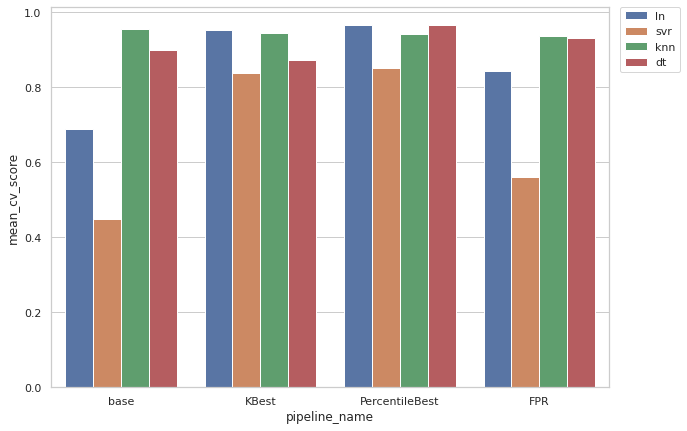

In [ ]:
fig = sns.barplot(
    data=results_df,
    x="pipeline_name",
    y="mean_cv_score",
    hue="model_name"
)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

---
### 2.2 Wrapper methods - Sequential Feature Selection

In wrapper methods, we try to use a subset of features and train a model using them. Based on the inferences that we draw from the previous model, we decide to add or remove features from our subset. The problem is essentially reduced to a search problem.

Wrapper methods follow a greedy search approach by evaluating all the possible combinations of features against the evaluation criterion. The evaluation criterion is simply the performance measure which depends on the type of problem, for e.g. For regression evaluation criterion can be p-values, R-squared, Adjusted R-squared, similarly for classification the evaluation criterion can be accuracy, precision, recall, f1-score, etc. Finally, they select the combination of features that gives the optimal subset of features most relevant to the problem.

Most commonly used techniques under wrapper methods are:
- **Forward selection**: adds features to form a feature subset in a greedy fashion.
- **Backward elimination**: removes features to form a feature subset in a greedy fashion.



There is built-in scikit-learn implementation: [`Sequential Feature Selector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html). At each stage [`Sequential Feature Selector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) chooses the best feature to add or remove based on the cross-validation score of an estimator.

Sequential Feature Selection is an example of **supervised feature selection**.

Example of the procedure for backward selection of features from [Bemister-Buffington et al. (2020)](https://www.mdpi.com/2218-273X/10/3/454#):

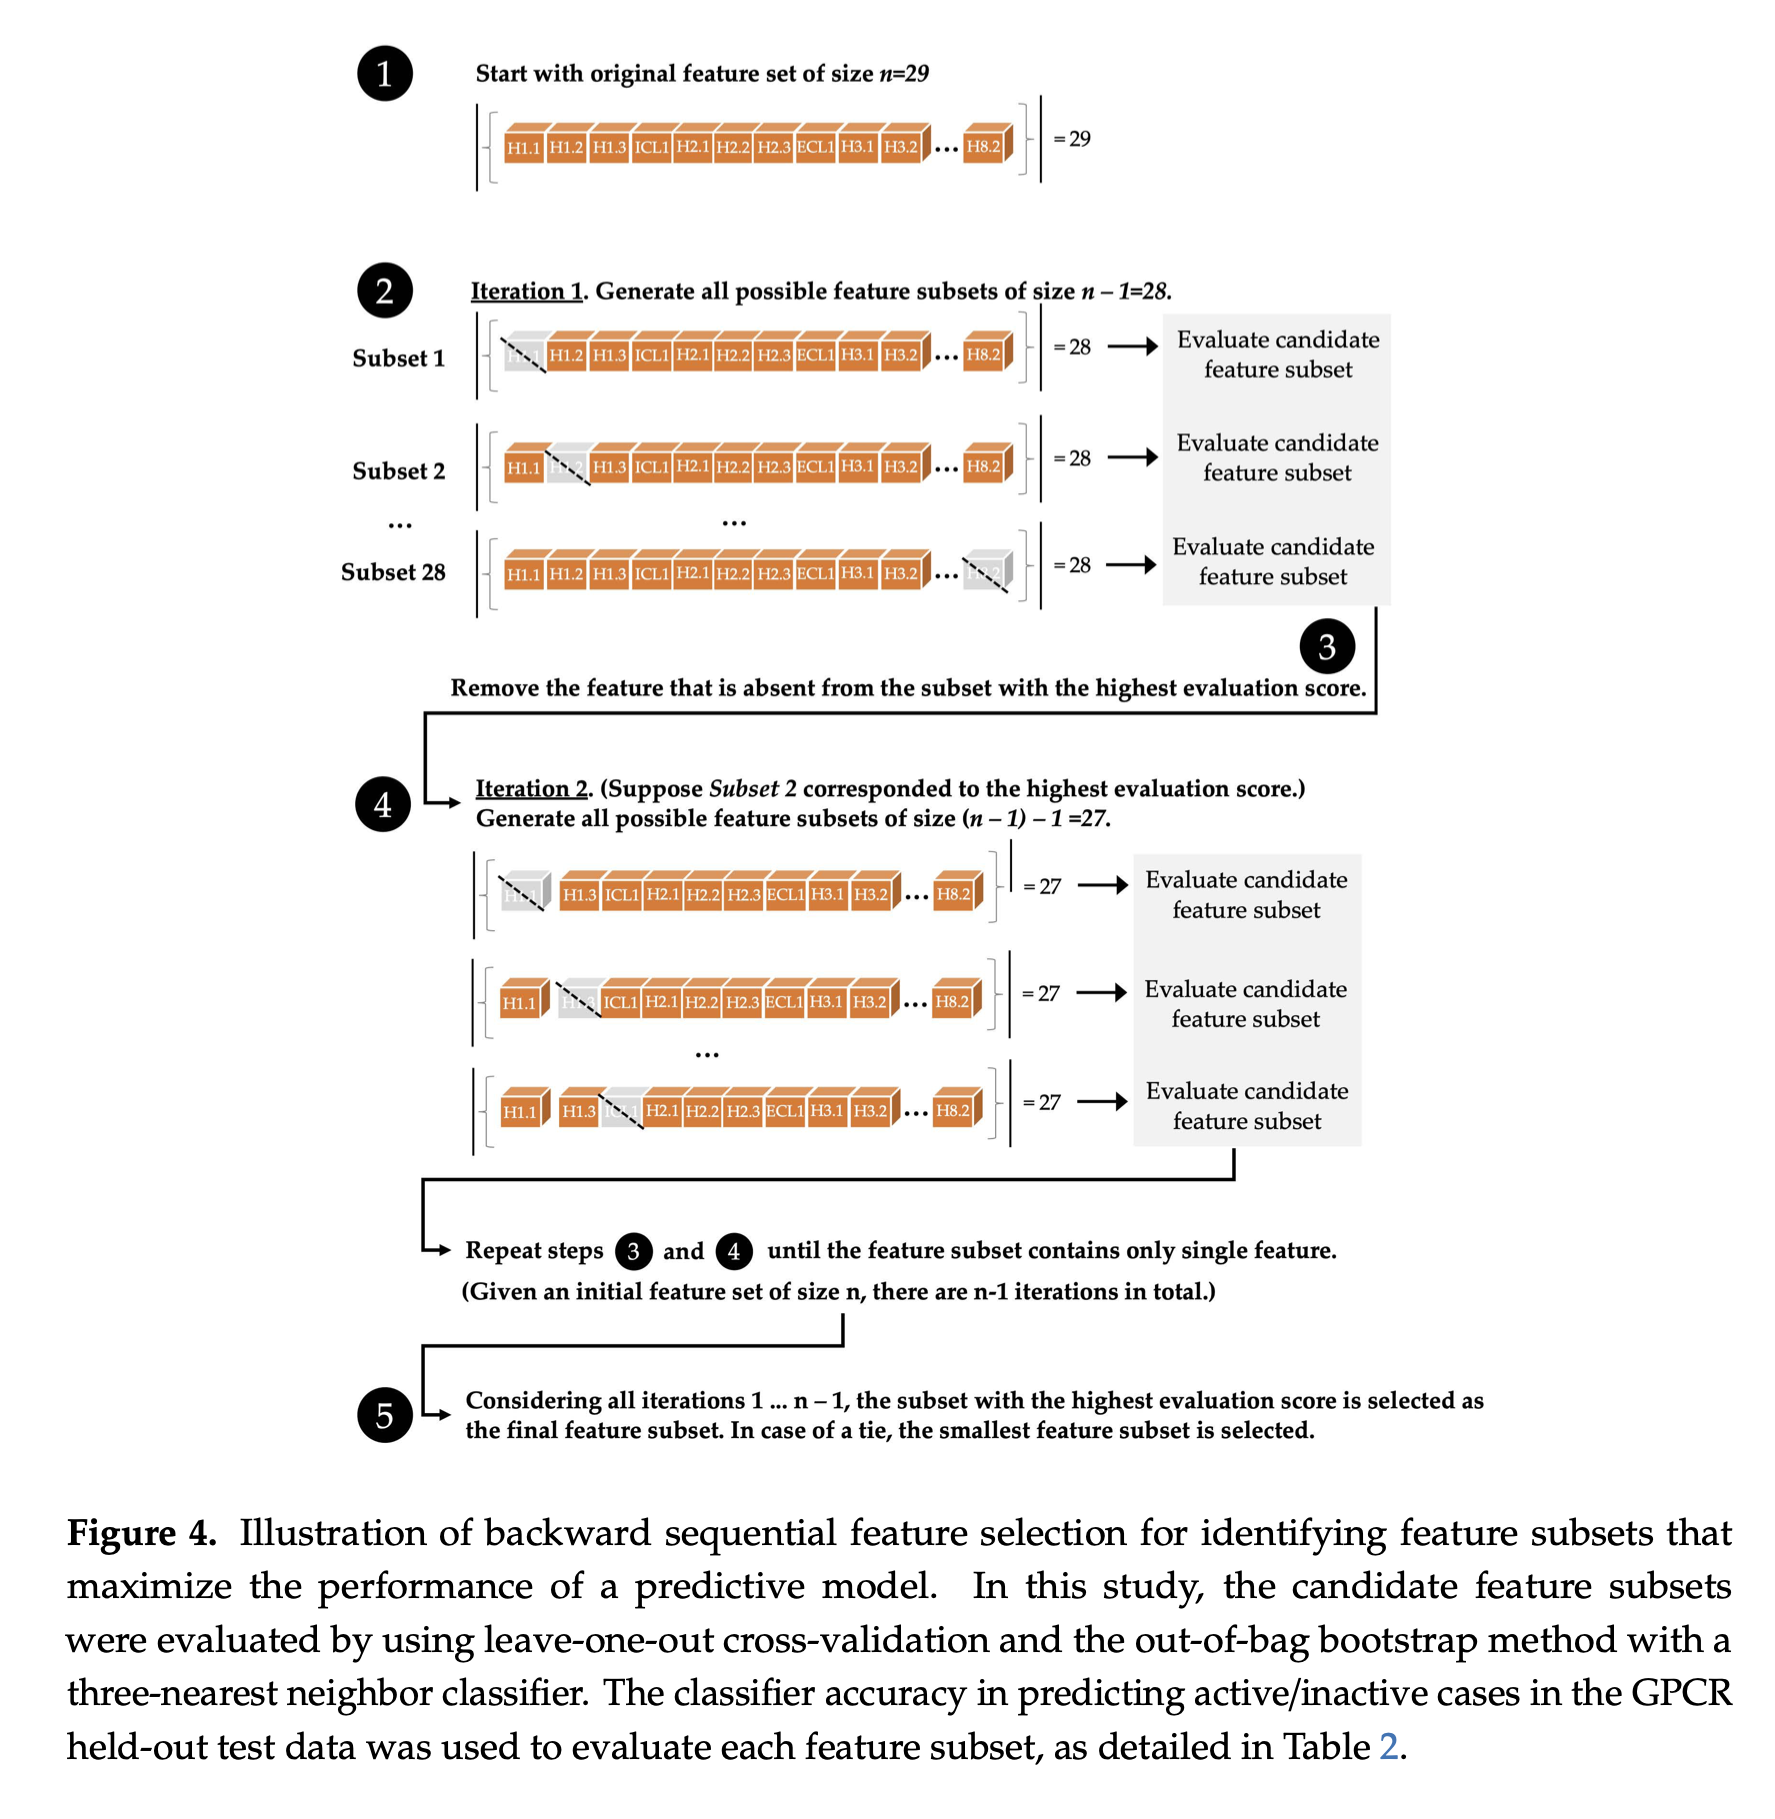

In sklearn, we can perform both forward and backward feature selection by setting the `direction` parameter. Let's take a look at this implementation:

In [ ]:
n_features_to_select = 5 # define number of features to select
pipeline_name = f"SFS"

base_steps = [
    ('scaler', StandardScaler())
]

Since `SequentialFeatureSelector()` is a supervised algorithm, it requires specifying an estimator. Therefore, in this algorithm, we need to specify the feature selection step **inside** the estimator loop. 

In [ ]:
for estimator in estimators:
  print(f"Rating {estimator} \n")

  estimator_name, estimator_model = estimator

  feature_selection_step = (
      'feature_selection', 
      SequentialFeatureSelector(
          estimator=estimator_model, 
          n_features_to_select=n_features_to_select, 
          cv=cv,
          direction = "forward" # define direction of selection
    )
  )

  # create pipeline from base steps list and estimator
  pipe = Pipeline(base_steps + [feature_selection_step] + [estimator])

  # enter to grid search
  this_results = evaluate_model(
      pipe,
      X_train,
      y_train,
      X_test,
      y_test,
      pipeline_name = pipeline_name,
      predict_test = True,
      predict_train = True,
  )

  results_df = results_df.append(this_results)

Rating ('ln', LinearRegression()) 

Rating ('svr', SVR()) 

Rating ('knn', KNeighborsRegressor()) 

Rating ('dt', DecisionTreeRegressor(random_state=42)) 



In [ ]:
results_df

,model_name,pipeline_name,train score,mean_cv_score,test_score,model
0,ln,base,0.999019,0.689423,-3.204231,"(StandardScaler(), LinearRegression())"
0,svr,base,0.740278,0.447586,0.633629,"(StandardScaler(), SVR())"
0,knn,base,0.987590,0.956695,0.963470,"(StandardScaler(), KNeighborsRegressor())"
0,dt,base,1.000000,0.898617,0.972479,"(StandardScaler(), DecisionTreeRegressor(rando..."
0,ln,KBest,0.979646,0.954118,0.888622,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,svr,KBest,0.882518,0.837028,0.735234,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,knn,KBest,0.979721,0.944716,0.972270,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,dt,KBest,1.000000,0.871734,0.894119,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,ln,PercentileBest,0.979637,0.965033,0.882059,"(StandardScaler(), SelectPercentile(percentile..."
0,svr,PercentileBest,0.896140,0.851523,0.714865,"(StandardScaler(), SelectPercentile(percentile..."


Inspect data after Sequential Feature selection:

In [ ]:
# extract pipe before estimator
sfs_pipe = results_df['model'].iloc[-1][:-1]
sfs_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SequentialFeatureSelector(cv=3,
                                           estimator=DecisionTreeRegressor(random_state=42),
                                           n_features_to_select=5))])

In [ ]:
# transform data
X_sfs = sfs_pipe.transform(X_test)
print(f"X set shape after feature selection: {X_sfs.shape}\n")

# print feature names that were selected
print(f"Selected Features: {*sfs_pipe.get_feature_names_out(),}")

X set shape after feature selection: (10, 5)

Selected Features: ('Adult Mortality', 'Total expenditure', ' HIV/AIDS', ' thinness  1-19 years', ' thinness 5-9 years')


### Plot the results

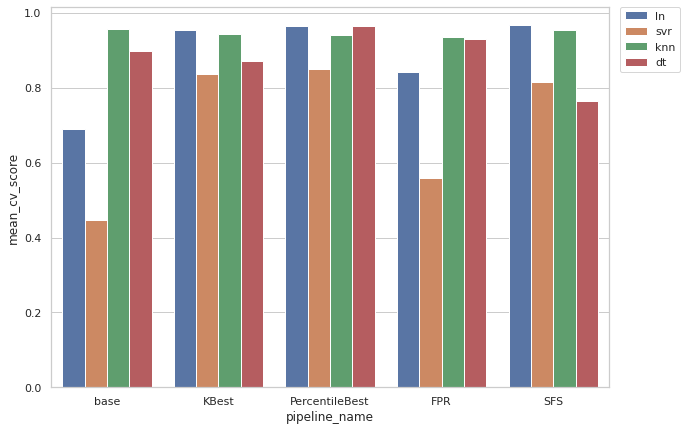

In [ ]:
fig = sns.barplot(
    data=results_df,
    x="pipeline_name",
    y="mean_cv_score",
    hue="model_name"
)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Compare selected features

You can extract mask of selected features with `.get_support()` method.

In [ ]:
feature_selection_df = pd.DataFrame({
    "features": X.columns.to_list(),
    "p-values": fpr_pipe["feature_selection"].pvalues_,
    "KBest": kbest_pipe["feature_selection"].get_support(),
    "Percentile": percentile_pipe["feature_selection"].get_support(),
    "FPR": fpr_pipe["feature_selection"].get_support(),
    "SFS": sfs_pipe["feature_selection"].get_support()
})

feature_selection_df.set_index('features', inplace=True)

In [ ]:
feature_selection_df

,p-values,KBest,Percentile,FPR,SFS
features,,,,,
Year,9.017695e-01,False,False,False,False
Adult Mortality,1.930062e-19,True,True,True,True
infant deaths,2.640337e-19,True,True,True,False
Alcohol,8.578724e-01,False,False,False,False
percentage expenditure,7.314180e-04,False,False,True,False
Hepatitis B,2.123903e-05,False,False,True,False
Measles,2.279102e-04,False,False,True,False
BMI,4.350341e-20,True,True,True,False
under-five deaths,3.375539e-23,True,True,True,False


### Difference between Filter and Wrapper methods

The main differences between the filter and wrapper methods for feature selection are:

- Filter methods measure the relevance of features by their correlation with dependent variable while wrapper methods measure the usefulness of a subset of feature by actually training a model on it.
- Filter methods are much faster compared to wrapper methods as they do not involve training the models. Wrapper methods are computationally very expensive.
- Filter methods use statistical methods for evaluation of a subset of features while wrapper methods use cross validation.
- Filter methods might fail to find the best (optimal for the problem) subset of features in many cases but wrapper methods can always provide the best subset of features.
- Using the subset of features from the wrapper methods make the model more prone to overfitting as compared to using subset of features from the filter methods.

## 3. Feature Extraction with PCA

**Feature Extraction aims to reduce the number of features in a dataset by creating new features from the existing ones (and then discarding the original features).** These new reduced set of features should then be able to summarize most of the information contained in the original set of features. In this way, a summarised version of the original features can be created from a combination of the original set.

Below we can explore feature extraction using scikit-learn [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [ ]:
# We set PCA n_components to 6
n_components = 6
pipeline_name = f"PCA_{n_components}"

base_steps = [
    ('scaler', StandardScaler()), 
    ('feature_extraction', PCA(n_components=n_components, random_state=random_state)),
]

In [ ]:
for estimator in estimators:
  print(f"Rating {estimator} \n")

  # create pipeline from base steps list and estimator
  pipe = Pipeline(base_steps + [estimator])

  # enter to grid search
  this_results = evaluate_model(
      pipe,
      X_train,
      y_train,
      X_test,
      y_test,
      pipeline_name = pipeline_name,
      predict_test = True,
      predict_train = True,
  )

  results_df = results_df.append(this_results)

Rating ('ln', LinearRegression()) 

Rating ('svr', SVR()) 

Rating ('knn', KNeighborsRegressor()) 

Rating ('dt', DecisionTreeRegressor(random_state=42)) 



In [ ]:
results_df

,model_name,pipeline_name,train score,mean_cv_score,test_score,model
0,ln,base,0.999019,0.689423,-3.204231,"(StandardScaler(), LinearRegression())"
0,svr,base,0.740278,0.447586,0.633629,"(StandardScaler(), SVR())"
0,knn,base,0.987590,0.956695,0.963470,"(StandardScaler(), KNeighborsRegressor())"
0,dt,base,1.000000,0.898617,0.972479,"(StandardScaler(), DecisionTreeRegressor(rando..."
0,ln,KBest,0.979646,0.954118,0.888622,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,svr,KBest,0.882518,0.837028,0.735234,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,knn,KBest,0.979721,0.944716,0.972270,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,dt,KBest,1.000000,0.871734,0.894119,"(StandardScaler(), SelectKBest(k=5, score_func..."
0,ln,PercentileBest,0.979637,0.965033,0.882059,"(StandardScaler(), SelectPercentile(percentile..."
0,svr,PercentileBest,0.896140,0.851523,0.714865,"(StandardScaler(), SelectPercentile(percentile..."


### Plot the results

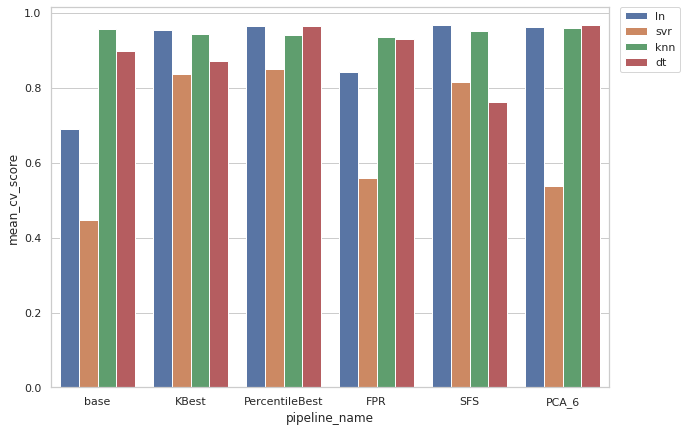

In [ ]:
fig = sns.barplot(
    data=results_df,
    x="pipeline_name",
    y="mean_cv_score",
    hue="model_name"
)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Inside PCA components 

To get to the PCA components, we have to access the fitted PCA object directly. 
1. we have to extract it from the df
2. then we have to extract it from Pipeline

In [ ]:
pca = results_df["model"].iloc[-1]["feature_extraction"]
pca

PCA(n_components=6, random_state=42)

#### 1. Explained Variance

Check the explained variance in %

In [ ]:
pca_explained_variance_ratio = pca.explained_variance_ratio_
print(f"Variance explainded by components (in %): {* np.round(pca_explained_variance_ratio*100, 2),}")

print(f"Variance explainded by all 6 components (in %): {sum(pca_explained_variance_ratio) * 100} %\n")

Variance explainded by components (in %): (53.64, 14.34, 12.3, 5.67, 4.28, 3.78)
Variance explainded by all 6 components (in %): 94.00129187719652 %



Plot the explained variance

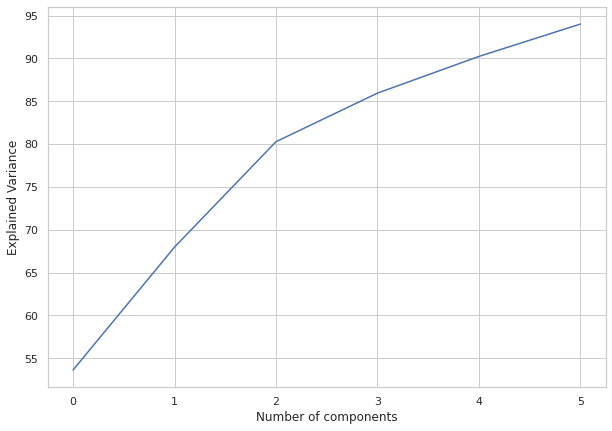

In [ ]:
fig = plt.plot(np.cumsum(pca_explained_variance_ratio * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")

plt.show()

#### 2. PCA vs orginal data

Let's look at the relationship between the original data and the PCA components. Try to look for answers to the following questions:

- What "high-level" features did PCA find?
- What is the relationship between the PCA components and the original data?

In [ ]:
# extract the coefficients of the original features for each component
pca_components = pca.components_

for i in range(0, len(pca_components)):
  print(f"Component {i}:\n {pca_components[i]}")

Component 0:
 [-0.04464446  0.27039617  0.29991245 -0.11451147 -0.20672433 -0.22504408
  0.14157413 -0.30075914  0.29536836 -0.27656312  0.1704122  -0.28664189
  0.05186986 -0.19620577 -0.02242274  0.2527682   0.25399275 -0.30913536
 -0.27813865]
Component 1:
 [ 0.24761556  0.26610263  0.12776747  0.42858987  0.128588   -0.05195299
  0.24240514 -0.10543489  0.16962356  0.03347056 -0.38759113  0.02716405
  0.57065778  0.21785542  0.07726163 -0.08687551 -0.09239137 -0.01823343
  0.04896457]
Component 2:
 [ 0.38664597  0.10217522  0.07933869 -0.27969728  0.36573857 -0.11088729
 -0.25581987  0.01705264  0.05582514 -0.03699553  0.0922051   0.02310304
 -0.07914799  0.3343001   0.47354558  0.27318885  0.26896837  0.03801463
  0.19883755]
Component 3:
 [-0.53466653 -0.02420779  0.03106812 -0.24614192  0.1724102  -0.2569912
  0.14979586  0.06246901  0.0158379  -0.14194979 -0.23077152 -0.19921445
 -0.05086981  0.20973449  0.44201425 -0.27466398 -0.27424353 -0.0305474
 -0.15167519]
Component 4:
 

In [ ]:
features = X.columns.to_list()

df = pd.DataFrame({
       "PCA_1": pca_components[0],
       "PCA_2": pca_components[1],
       "PCA_3": pca_components[2],
       "PCA_4": pca_components[3],
       "PCA_5": pca_components[4],
       "PCA_6": pca_components[5],
       "features": features,
})

df.set_index('features', inplace=True)

In [ ]:
df

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6
features,,,,,,
Year,-0.044644,0.247616,0.386646,-0.534667,0.216067,0.324346
Adult Mortality,0.270396,0.266103,0.102175,-0.024208,-0.037646,0.064957
infant deaths,0.299912,0.127767,0.079339,0.031068,-0.086109,0.023765
Alcohol,-0.114511,0.428590,-0.279697,-0.246142,-0.176471,-0.132237
percentage expenditure,-0.206724,0.128588,0.365739,0.172410,-0.343003,0.252549
Hepatitis B,-0.225044,-0.051953,-0.110887,-0.256991,-0.389153,0.156144
Measles,0.141574,0.242405,-0.255820,0.149796,0.407976,0.621111
BMI,-0.300759,-0.105435,0.017053,0.062469,0.098161,0.072588
under-five deaths,0.295368,0.169624,0.055825,0.015838,-0.115858,-0.000723


Plot the relationship between PCA components and the original data

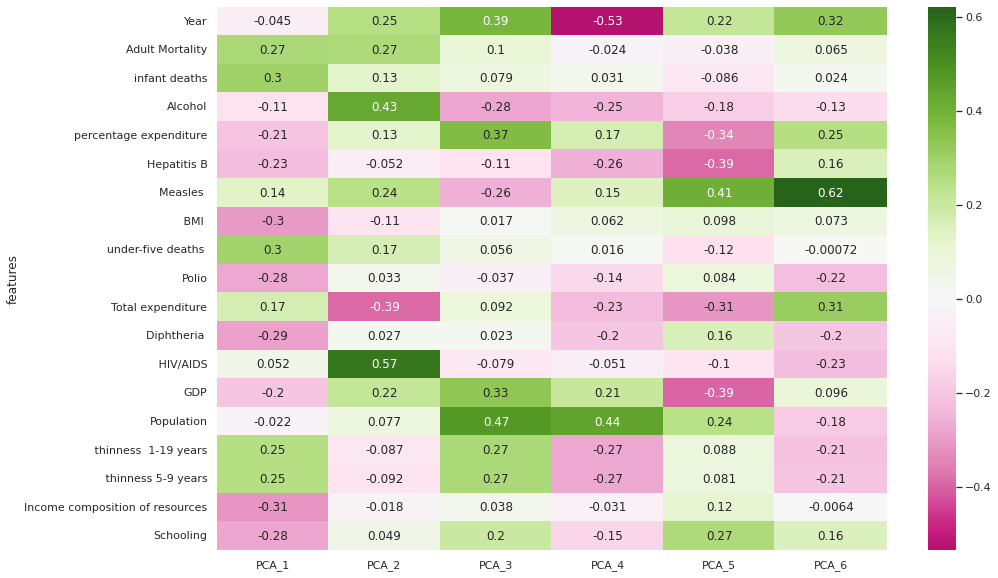

In [ ]:
plt.figure(figsize=(15,10))

fig = sns.heatmap(
      data = df, 
      center=0,
      annot=True,
      cmap="PiYG",
)

We can also define PCA with the desired amount of explained variance, letting the PCA to choose right amount of components.

### PCA as a tool for pattern detection

When we talking about plots, it is not possible to create a scatterplot for the original dataset because it contains 30 features. Reducing the number of dimensions down to two or three makes it possible to create a 2d or 3d plots which helps us to detect patterns. 

Let's see the plot for 2 components.

In [ ]:
n_components = 2

base_steps = [
    ('scaler', StandardScaler()), 
    ('feature_extraction', PCA(n_components=n_components, random_state=random_state)),
]

In [ ]:
# fit transform data
X_pca_2 = Pipeline(base_steps).fit_transform(X)
print(f"X PCA 2 shape: {X_pca_2.shape}")

X PCA 2 shape: (50, 2)


In [ ]:
pca_2_df = pd.DataFrame({
    "PCA_1": X_pca_2[:,0],
    "PCA_2": X_pca_2[:,1],
    "Life Expectancy": y.to_numpy().ravel(),
})
pca_2_df = pca_2_df.round(2)

pca_2_df.head()

,PCA_1,PCA_2,Life Expectancy
0,3.24,-0.68,65.0
1,2.74,-0.84,59.9
2,2.75,-0.74,59.9
3,2.91,-0.79,59.5
4,3.12,-0.88,59.2


PCA components vs Life Expectancy

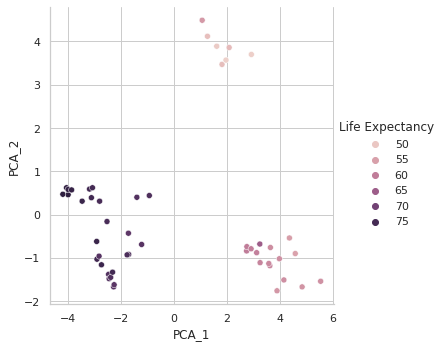

In [ ]:
fig = sns.relplot(
    data=pca_2_df,
    x="PCA_1", y="PCA_2",
    hue="Life Expectancy",
)

# Extra ⛵

To see error bars of CV scores, we have to encode each CV score in one row.

In [ ]:
results_cv_df = pd.DataFrame()

In [ ]:
for index, row in results_df.iterrows():
  cv_scores = row.cv_scores

  for cv_score in cv_scores:
    this_results = pd.DataFrame({
        "model_name": [row.model_name],
        "pipeline_name": [row.pipeline_name],
        "train score": [row["train score"]],
        "test_score": [row.test_score],
        "mean_cv_score": [row.mean_cv_score],
        "cv_score": [cv_score],
    })
    results_cv_df = results_cv_df.append(this_results)

In [ ]:
results_cv_df.head()

,model_name,pipeline_name,train score,test_score,mean_cv_score,cv_score
0,ln,base,0.999019,-3.204231,0.689423,0.961043
0,ln,base,0.999019,-3.204231,0.689423,0.116303
0,ln,base,0.999019,-3.204231,0.689423,0.990923
0,svr,base,0.740278,0.633629,0.447586,0.308379
0,svr,base,0.740278,0.633629,0.447586,0.487082


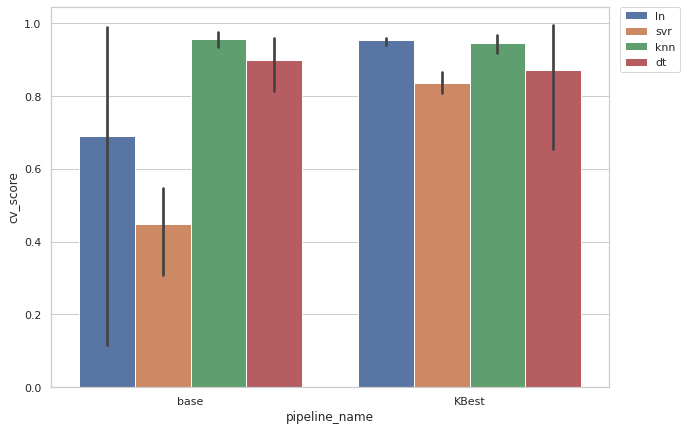

In [ ]:
plt.figure(figsize=(10,7))

fig = sns.barplot(
    data=results_cv_df,
    x="pipeline_name",
    y="cv_score",
    hue="model_name"
)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

# And this is the end :)

# Recap:
* Feature Selection:
  * filter methods that use statistical tests;
  * wrapped methods that are computationally expensive but select the feature most relevant to the problem explicite;
  * usually supervised lerning;
* Feature Extraction:
  * It reduce the number of features in a dataset by creating new features from the existing ones.
  * Can be performed with Principal Component Analysis that is unsupervised algorithm. 


# TODO 🔥

1. We're going to develop Perfectionism_project.ipynb further - EEG vs CMDA Perfectionism;
2. Operationalize the EEG signal in the **following three different ways**:
  - like before - one feature: 
    - select one electrode;
    - select time window 0-100 ms;
    - average data in selected time window;
  - feature selection:
    - take a subset od electrodes: F1, Fz, F2, FC1, FCz, FC2, C1, Cz, C2, CP1, CPz, CP2;
    - select time window 0-100 ms;
    - (optionally average data in selected time window for each channels separately) 
    - add feature selection step to your Pipeline with the method of your choice (filter or wrapper) with the hyperparameters of method (KBest, Percentile, N_features) trained in Grid Search.
  - feature extraction:
    - take a subset od electrodes: F1, Fz, F2, FC1, FCz, FC2, C1, Cz, C2, CP1, CPz, CP2;
    - select time window 0-100 ms;
    - add feature extraction step to your Pipeline with the number of components from 1 to 10 trained in Grid Search.
3. Test the same models as before: Linear Regression, KNN and SVR with Grid Seach for optimal hyperparameters. Remember to name your pipelines. You can use `evaluate_model()` method from this notebook. 
4. Visualize the results of different models and Pipelines. 